In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tftables
import time

import data_loader
import model_short as model
import toy_data_loader

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.set_printoptions(suppress=True, precision=3)

In [3]:
class hps:
    pass
hps.n_levels = 1 # number of splits
hps.depth = 1 # number of layers in revnet
hps.width = 4 # channels in revnet layers
hps.polyak_epochs = 1
hps.beta1 = .9 # learning rate annealing factor
hps.weight_decay = 1 # learning rate annealing factor
hps.lr = .001 # base learning rate
hps.epochs = 10
hps.epochs_warmup = 2
hps.n_data = 8000 # number of input spectra
hps.batch_size = 50 # number of spectra in a batch
hps.n_batches = int(hps.n_data / hps.batch_size)
hps.n_bins = 40000

In [4]:
sess = tf.InteractiveSession()

In [5]:
# select real or toy data by uncommenting the appropriate line
# real data must have n_data=8000, n_bins=40000
input_stream, initialize_input_stream, data_init = data_loader.create_data_loader(
#input_stream, initialize_input_stream, data_init = toy_data_loader.create_data_loader(
    sess, hps.batch_size, hps.n_data, hps.n_bins
)

W0202 02:57:07.407628 140218335012608 deprecation_wrapper.py:119] From /home/tey/env/lib/python3.5/site-packages/tftables.py:210: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0202 02:57:07.418716 140218335012608 deprecation.py:323] From /home/tey/glow/data_loader.py:9: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0202 02:57:07.431082 140218335012608 deprecation_wrapper.py:119] From /home/tey/env/lib/python3.5/site-packages/tftables.py:456: The name tf.FIFOQueue is deprecated. Please use tf.queue.FIFOQueue instead.



(50, 40000, 1)


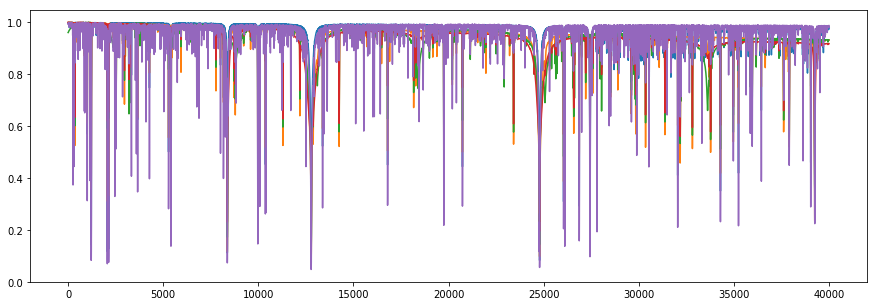

In [6]:
print(data_init.shape)
plt.figure(figsize=(15, 5))
for spectrum in data_init[:5]:
    plt.plot(spectrum)

In [7]:
with tf.device("/device:GPU:0"):
    m = model.model(sess, hps, input_stream, data_init)

W0202 02:57:09.692455 140218335012608 deprecation.py:506] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0202 02:57:09.750644 140218335012608 deprecation_wrapper.py:119] From /home/tey/glow/tfops_short.py:102: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



original shape (50, 40000, 1)
encoding z (50, 10000, 4)
creating revnet level 0 (50, 10000, 4)
actnorm_scale (50, 10000, 4) (1, 1, 4) 10000
calculating prior (50, 10000, 4)


W0202 02:57:10.289495 140218335012608 deprecation.py:323] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/training/moving_averages.py:433: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


original shape (?, 40000, 1)
encoding z (?, 10000, 4)
creating revnet level 0 (?, 10000, 4)
actnorm_scale (?, 10000, 4) (1, 1, 4) 10000
calculating prior (?, 10000, 4)


In [8]:
%%time
m.train(.001)

CPU times: user 260 ms, sys: 56 ms, total: 316 ms
Wall time: 250 ms


array([-0.613], dtype=float32)

In [ ]:
n_processed = 0

hps.epochs = 1
hps.epochs_warmup = 1
hps.print_freq = 10

for epoch in range(1, hps.epochs + 1):
    train_results = []
    initialize_input_stream()
    epoch_start_time = time.time()
    for iteration in range(hps.n_batches):
        lr = hps.lr * min(1., n_processed / (hps.batch_size * hps.n_batches * hps.epochs_warmup))
        start_time = time.time()
        train_results += [m.train(lr)]
        n_processed += hps.batch_size
        if epoch == 1 and iteration % hps.print_freq == 0:
            print(epoch, iteration, np.round(time.time() - start_time, 3), train_results[-1][0])
    print(epoch, np.round(time.time() - epoch_start_time, 3), np.round(np.mean(train_results, axis=0), 3))

1 0 0.025 -1.3049064
1 10 1.613 -0.7074079
1 20 1.93 -1.1886096
1 30 1.841 -0.7253486
1 40 1.47 -1.3370668
1 50 1.588 -0.83517915
1 60 1.404 -1.2289977
1 70 1.45 -0.6656
1 80 1.479 -1.1298304
1 90 1.842 -1.1407262
1 100 1.863 -0.7448271
1 110 1.354 -0.9149107
1 120 1.803 -1.3652577


In [ ]:
i = np.random.randint(0, 50)
sample_data = data_init[i:i+1, :, :]
print(i)

In [ ]:
latent_rep = sess.run(m.encode(m.X), feed_dict={m.X: sample_data})
spectrum = sess.run(m.decode(m.encode(m.X)), feed_dict={m.X: sample_data})

In [ ]:
print(latent_rep.mean(), latent_rep.std())

In [ ]:
plt.plot(latent_rep[0, :, 0])
plt.plot(latent_rep[0, :, 1])
plt.plot(latent_rep[0, :, 2])
plt.plot(latent_rep[0, :, 3])

In [ ]:
plt.plot(latent_rep[0, :, 0])
#plt.plot(latent_rep[0, :, 1])
#plt.plot(latent_rep[0, :, 2])
#plt.plot(latent_rep[0, :, 3])

In [ ]:
plt.plot(np.squeeze(spectrum))
plt.plot(np.squeeze(sample_data))

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(np.squeeze(np.clip(spectrum, 0, 1)))
plt.plot(np.squeeze(sample_data))
#plt.xlim(12000, 14000)
plt.xlim(hps.n_bins*.4, hps.n_bins*.6)

plt.subplot(2, 1, 2)
plt.plot(np.squeeze(np.clip(spectrum, 0, 1)) - np.squeeze(sample_data))
#plt.xlim(12000, 14000)
plt.xlim(hps.n_bins*.4, hps.n_bins*.6)